# Filtros FIR

Para crear un filtro FIR, debemos seguir los pasos:
1. Definir frecuencias que se desea eliminar: pasa bajo $[0,f]$, pasa alto $[f,f_m]$, pasa banda $[f_1,f_2]$, rechaza banda $[0,f_1)(f_2,f_m]$
2. Antitransformar
3. Aplicar ventana de N muestras (cualquiera)
4. Aplicar desplazamiento de $\frac{N-1}{2}$ muestras. Para esto utilizar la propiedad de retardo de la TDF
$$x[n-i] \xLeftrightarrow{\mathcal{F}} X[k]e^{-j\omega i}$$
Obviamente vamos a aplicarlo antes de antitransformar, pero se menciona aca para que se entienda el por qué.

5. Obtener respuesta al impulso

# Rechaza banda

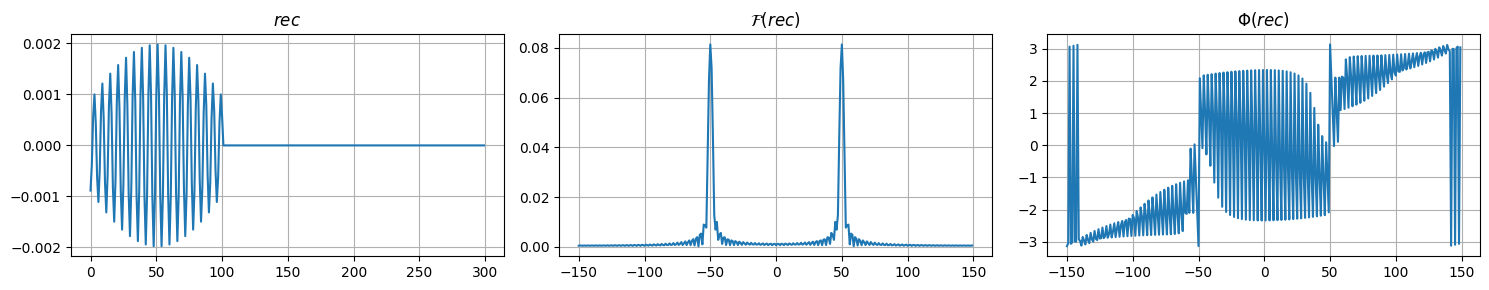

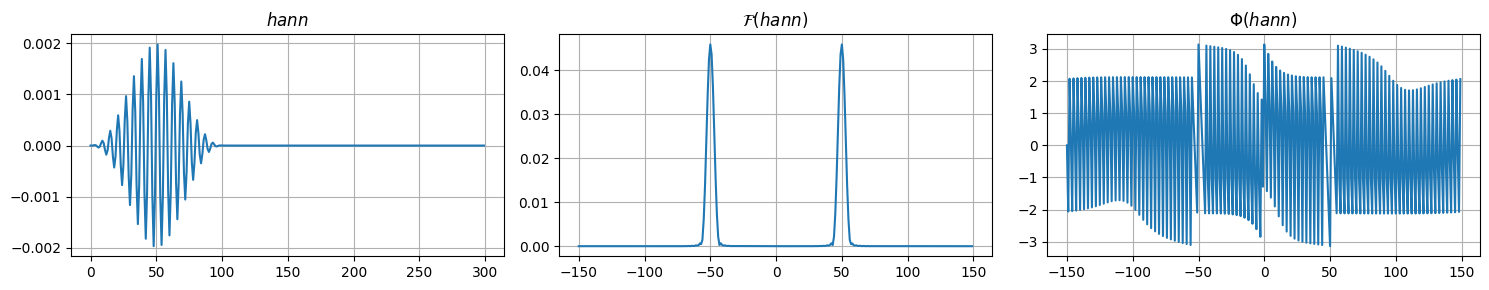

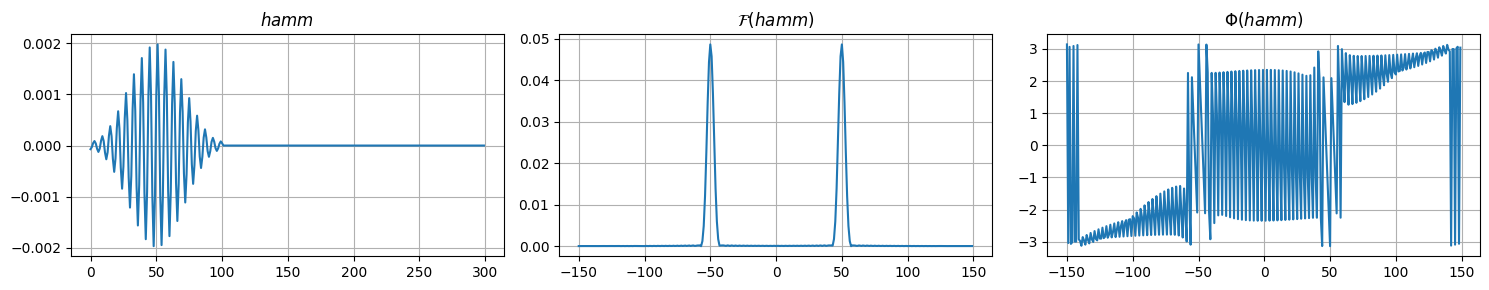

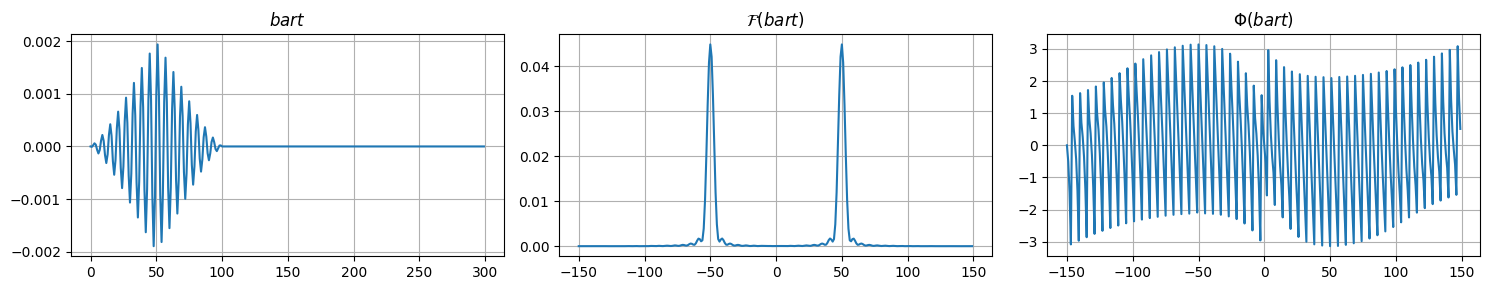

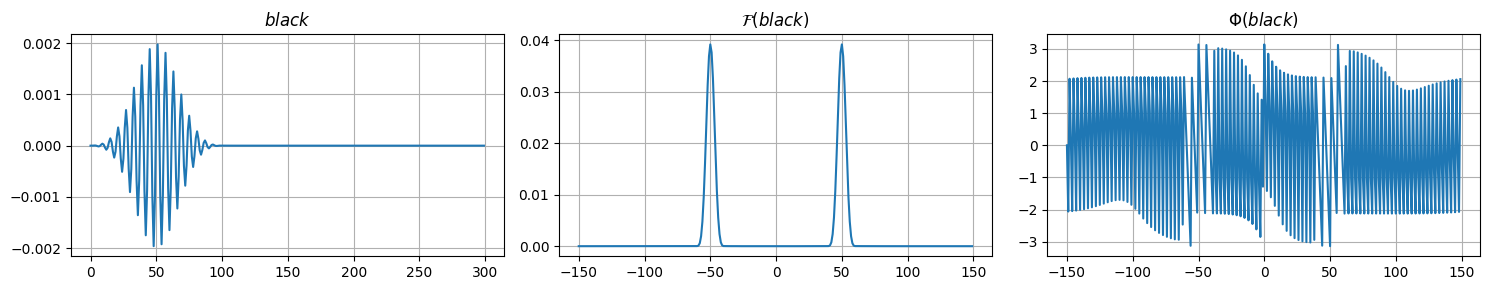

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin
from testFiltro import testFiltro

def rectangular(s,Nini,Nfin):
    '''Ventana rectangular aplicada a s entre las muestras Nini y Nfin'''
    w = np.ones(Nfin-Nini)
    if Nini > 0:
        w = np.concatenate([np.zeros(Nini-1),w])
    if Nfin < len(s):
        w = np.concatenate([w,np.zeros(len(s)-len(w))])

    return np.multiply(w,s)

def hann(s,Nini,Nfin):
    '''Ventana de Hann aplicada a s entre las muestras Nini y Nfin'''
    N = Nfin-Nini
    n = np.linspace(0,N,N)

    aux = 2*np.pi/N
    w = [0.5 for _ in range(N)] - 0.5 * np.cos(aux*n)
    if Nini > 0:
        w = np.concatenate([np.zeros(Nini-1),w])
    if Nfin < len(s):
        w = np.concatenate([w,np.zeros(len(s)-len(w))])

    return np.multiply(w,s)

def hamming(s,Nini,Nfin):
    '''Ventana de Hamming aplicada a s entre las muestras Nini y Nfin'''
    N = Nfin-Nini
    n = np.linspace(0,N,N)

    aux = 2*np.pi/N
    w = [27/50 for _ in range(N)] - 23/50 * np.cos(aux*n)
    if Nini > 0:
        w = np.concatenate([np.zeros(Nini-1),w])
    if Nfin < len(s):
        w = np.concatenate([w,np.zeros(len(s)-len(w))])

    return np.multiply(w,s)

def bartlett(s,Nini,Nfin):
    '''Ventana de Bartlett aplicada a s entre las muestras Nini y Nfin'''
    N = Nfin-Nini
    n = np.linspace(0,N,N)

    aux = 2.0/N
    w = np.where(np.less_equal(n,N/2.0),n*aux,[2 for _ in range(N)] - n*aux)
    if Nini > 0:
        w = np.concatenate([np.zeros(Nini-1),w])
    if Nfin < len(s):
        w = np.concatenate([w,np.zeros(len(s)-len(w))])

    return np.multiply(w,s)

def blackman(s,Nini,Nfin):
    '''Ventana de Blackman aplicada a s entre las muestras Nini y Nfin'''
    N = Nfin-Nini
    n = np.linspace(0,N,N)

    aux = 2*np.pi/N
    w = [21/50 for _ in range(N)] - 0.5*np.cos(aux*n) + (2/25)*np.cos(2*aux*n)
    if Nini > 0:
        w = np.concatenate([np.zeros(Nini-1),w])
    if Nfin < len(s):
        w = np.concatenate([w,np.zeros(len(s)-len(w))])

    return np.multiply(w,s)

def pasaaltoFreq(N,fmin, fmax):
    '''genera el espectro idea de un filtro rechaza banda'''
    f = np.arange(N)
    dAng = 2*np.pi/N
    pasatodo = [np.cos(k*dAng) + 1j*np.sin(k*dAng) for k in f]
    pasanada = np.multiply(pasatodo,np.zeros(N))
    H = np.where(np.less(f,fmin),pasatodo,pasanada)                               # [0:fmin]
    H = np.where(np.logical_and(np.greater(f,fmax),np.less(f,N-fmax)), pasatodo, H)   # [fmax:fm-fmax]
    H = np.where(np.greater(f,N-fmin),pasatodo,H)                                   # [fm-fmin:fm]
    return H

def retardar(X,i):
    N = len(X)
    k = np.arange(N)
    exp = np.exp(-2j*np.pi*k*i/N)
    Xret = X*exp
    return Xret

def FIRRechazaBanda(N, f1, f2, W):
    """
    Generate an FIR bandstop filter with N coefficients.
    
    Parameters:
        N  : int     - Number of coefficients (should be odd for symmetry)
        f1 : float   - Lower cutoff frequency (normalized, e.g. 0.1)
        f2 : float   - Upper cutoff frequency (normalized, e.g. 0.3)
        W  : array   - Window of length N to apply (e.g., np.hamming(N))
    
    Returns:
        h : np.array - Impulse response of the bandstop filter
    """
    if N % 2 == 0:
        raise ValueError("N should be odd for symmetric FIR filters")

    # Frequency response: 1 where we pass, 0 where we block (between f1 and f2)
    H = np.ones(N, dtype=complex)
    k = np.arange(N)
    f = k / N  # normalized frequency bins

    # Zero out the band [f1, f2] and its mirrored part for real signal symmetry
    H[(f >= f1) & (f <= f2)] = 0
    H[(f >= (1 - f2)) & (f <= (1 - f1))] = 0

    # Inverse DFT to get impulse response (non-causal)
    h = np.fft.ifft(H).real

    # Shift to make it causal (centered at N//2)
    h = np.roll(h, -N//2)

    # Apply window
    h = W(h,0,N)

    return h

# Parametros
fm = 300
bandaMin = 49/fm
bandaMax = 51/fm
longitud = 101

sTest = np.fft.ifft(np.ones(fm)).real

hrectangular = FIRRechazaBanda(longitud,bandaMin,bandaMax,rectangular)
hhann = FIRRechazaBanda(longitud,bandaMin,bandaMax,hann)
hhamming = FIRRechazaBanda(longitud,bandaMin,bandaMax,hamming)
hbartlett = FIRRechazaBanda(longitud,bandaMin,bandaMax,bartlett)
hblackman = FIRRechazaBanda(longitud,bandaMin,bandaMax,blackman)

testFiltro(np.convolve(sTest,hrectangular)[:300],'rec')
testFiltro(np.convolve(sTest,hhann)[:300],'hann')
testFiltro(np.convolve(sTest,hhamming)[:300],'hamm')
testFiltro(np.convolve(sTest,hbartlett)[:300],'bart')
testFiltro(np.convolve(sTest,hblackman)[:300],'black')

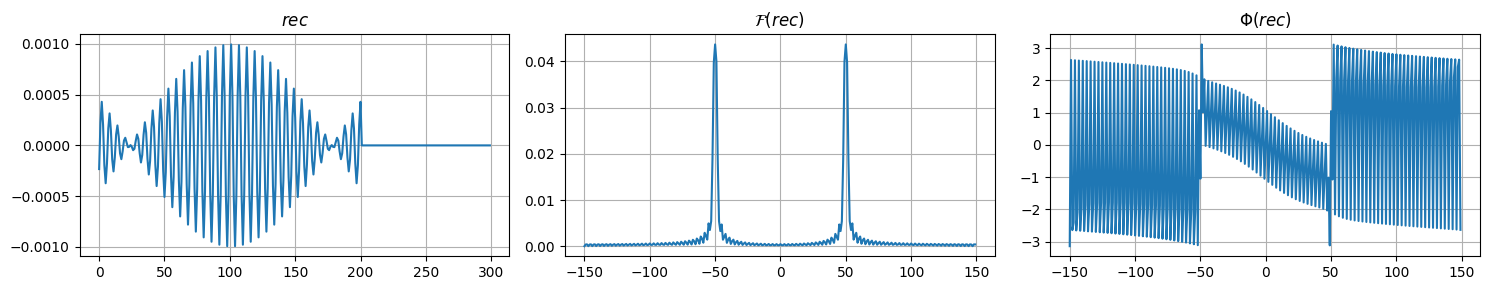

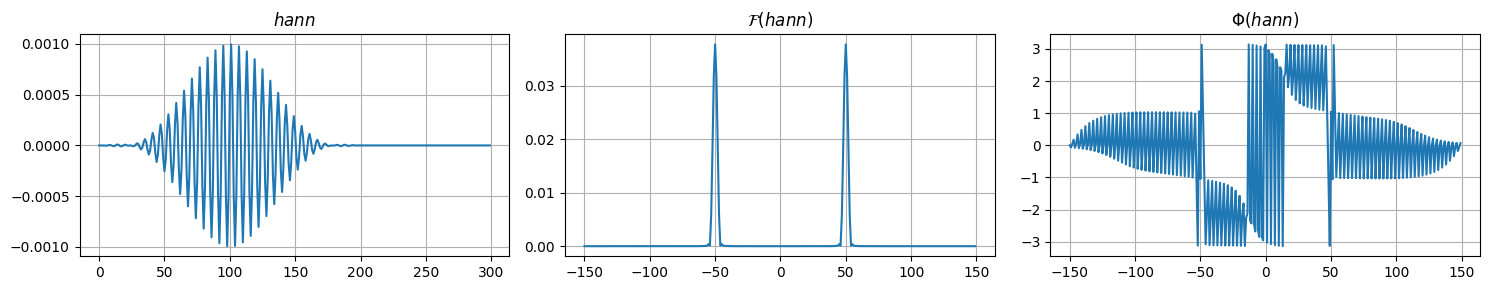

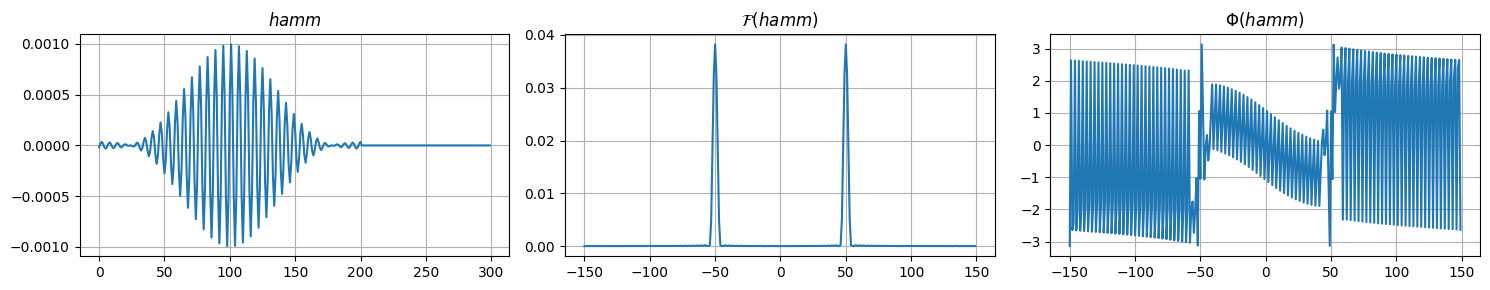

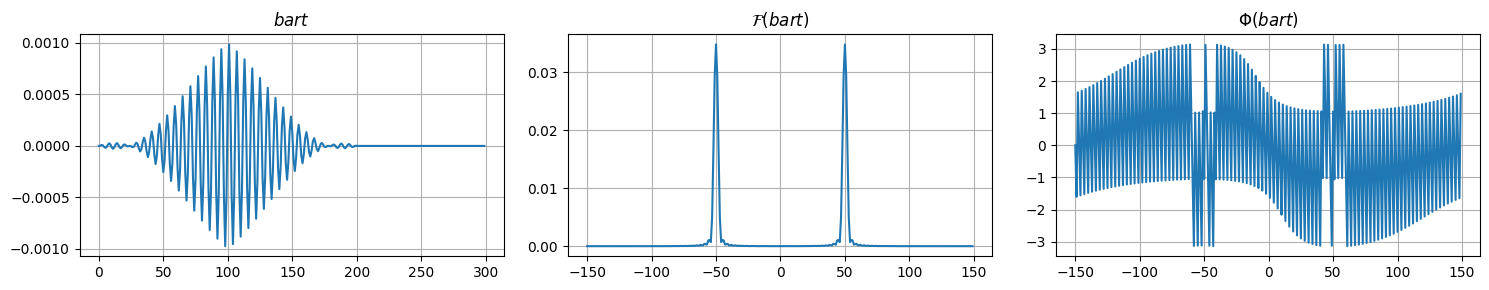

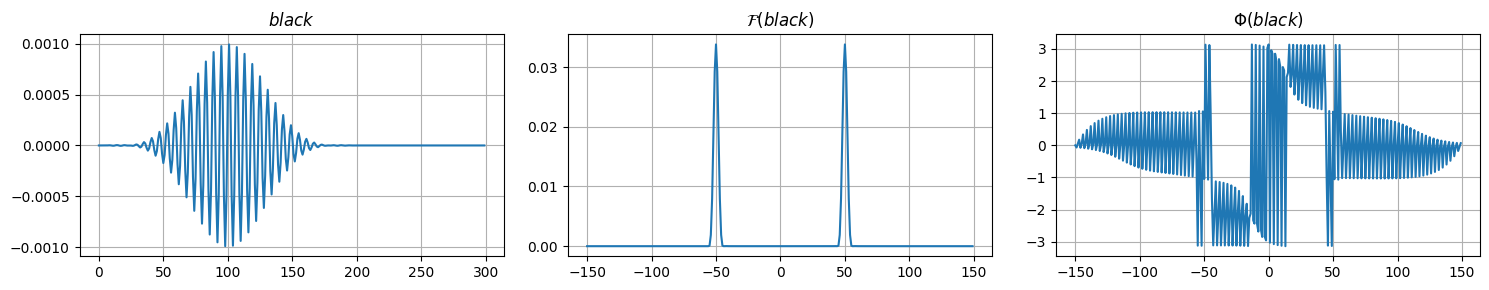

In [3]:
longitud = 201

hrectangular = FIRRechazaBanda(longitud,bandaMin,bandaMax,rectangular)
hhann = FIRRechazaBanda(longitud,bandaMin,bandaMax,hann)
hhamming = FIRRechazaBanda(longitud,bandaMin,bandaMax,hamming)
hbartlett = FIRRechazaBanda(longitud,bandaMin,bandaMax,bartlett)
hblackman = FIRRechazaBanda(longitud,bandaMin,bandaMax,blackman)

testFiltro(np.convolve(sTest,hrectangular)[:300],'rec')
testFiltro(np.convolve(sTest,hhann)[:300],'hann')
testFiltro(np.convolve(sTest,hhamming)[:300],'hamm')
testFiltro(np.convolve(sTest,hbartlett)[:300],'bart')
testFiltro(np.convolve(sTest,hblackman)[:300],'black')